# 17. 회귀

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import set_pyplot_params
set_pyplot_params()

<br>

## 17.01. 강설량 예측

>메사추세츠 주의 노포크 카운티는 과거 눈이 [27인차](https://en.wikipedia.org/wiki/Northeastern_United_States_blizzard_of_1978)만큼 내렸지만, 최근에는 많이 내리지 않는다. 노포크 카운티에는 블루힐에 대한 강설량은 [블루힐 기상관측소](https://en.wikipedia.org/wiki/Blue_Hill_Meteorological_Observatory)에 존재한다. [미국 해양 대기정(NOAA)](https://www.ncdc.noaa.gov/cdo-web/search)에서 블루힐 기상관측소와 여러 다른 기상청의 데이터를 확인할 수 있으며, 1967년 3월 11일 부터, 2020년 5월 11일까지의 데이터를 확인

In [3]:
import pandas as pd

In [4]:
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/data/2239075.csv')

In [5]:
df = pd.read_csv('2239075.csv', parse_dates=[2])

In [6]:
df.tail(3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
19357,USC00190736,"BLUE HILL COOP, MA US",2020-05-09,0.45,0.0,0.0,57,34.0,34.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19358,USC00190736,"BLUE HILL COOP, MA US",2020-05-10,0.00,0.0,0.0,44,31.0,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19359,USC00190736,"BLUE HILL COOP, MA US",2020-05-11,0.00,0.0,0.0,59,38.0,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df['YEAR'] = df['DATE'].dt.year
snow = df.groupby('YEAR')['SNOW'].sum()

In [11]:
snow.head()

YEAR
1967    28.6
1968    44.7
1969    99.2
1970    66.8
1971    54.6
Name: SNOW, dtype: float64


* `YEAR` : 연도

* `SNOW` : 연도 별 강설량 합계 (인치)



In [12]:
snow = snow.iloc[1:-1]
len(snow)

52

<br>

#### 강설량 산점도

In [13]:
from utils import decorate

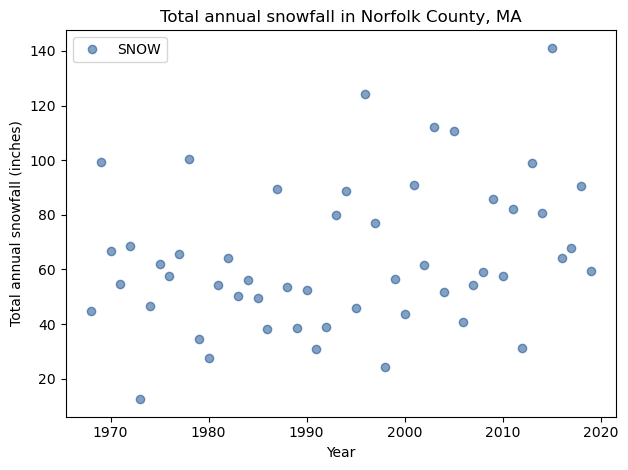

In [14]:
snow.plot(ls='', marker='o', alpha=0.5)

decorate(xlabel='Year', ylabel='Total annual snowfall (inches)', title='Total annual snowfall in Norfolk County, MA')

#### 지난 10년간은 1978년보다 더 눈이 많이 온 해도 존재
#### 2015년의 경우, 보스턴 지역은 총 141인치의 눈이 오면서, 현대 역사상 가장 눈이 많이 온 겨울
#### 데이터에 대하여 상승 경향성이 있는지, 하강 경향성이 있는지를 분석

In [16]:
snow.loc[[1978, 1996, 2015]]

YEAR
1978    100.6
1996    124.2
2015    141.1
Name: SNOW, dtype: float64

<br>

## 17.02. 회귀 모형

<br>

#### 회귀의 기본 형태


$$y = a x + b + \epsilon$$

- $y$ : 측정값 (반응변수, 종속변수)
- $x$ : 설명변수, 독립변수
- $\epsilon$ : 오차
    - $\epsilon$의 분포는 알 수 없으므로, 평균 0에 알려지지 않은 표준편차 $\sigma$의 정규분포를 따른다고 가정
- $a$ : 기울기
- $b$ : 절편

<br>

#### 강설량에 대한 균등분포 Pmf 객체

In [18]:
from empiricaldist import Pmf

In [20]:
pmf_snowfall = Pmf.from_seq(snow)
pmf_snowfall.head()

,probs
12.5,0.019231
24.1,0.019231
27.7,0.019231


#### 평균과 표준편차

In [21]:
mean, std = pmf_snowfall.mean(), pmf_snowfall.std()
mean, std

(64.19038461538462, 26.28802198439569)

<br>

#### 강설량의 평균과 표준편차를 갖는 정규분포의 누적분포함수 

In [33]:
from scipy.stats import norm
import matplotlib.pyplot as plt

In [34]:
dist = norm(mean, std)
qs = pmf_snowfall.qs
ps = dist.cdf(qs)

<br>

#### 강설량에 대한 균등분포의 누적분포와의 비교

- **강설량에 대한 균등분포의 누적분포가, 강설량의 평균과 표준편차를 따르는 정규분포의 누적분포와 어느정도 유사함을 가짐**

    **$\rightarrow$ 전반적으로 설득력 있는 가정으로 판단 가능**

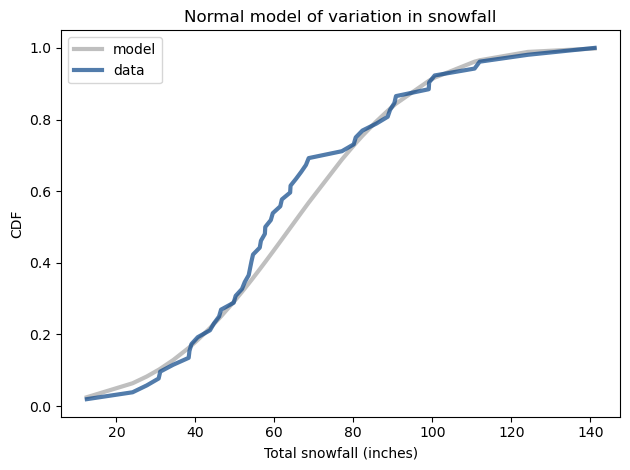

In [35]:
plt.plot(qs, ps, color='C5', label='model')
pmf_snowfall.make_cdf().plot(label='data')

decorate(xlabel='Total snowfall (inches)', ylabel='CDF', title='Normal model of variation in snowfall')

<br>

## 17.03. 최소제곱회귀

<br>

### 회귀모형은 기울기 `slope`, 절편 `intercept`, 오차 의 표준편차 `sigma`까지 3개의 매개변수를 가짐

#### 실증적 베이지안 방법론 적용을 위하여, `statsmodel`라이브러리의 최소제곱회귀를 사용

In [40]:
data = snow.reset_index()
data.head(3)

,YEAR,SNOW
0,1968,44.7
1,1969,99.2
2,1970,66.8


#### 설명변수 `YEAR`에 대한 표준화 (평균을 빼서 0으로 중심화 조정)

In [41]:
offset = round(data['YEAR'].mean())
data['x'] = data['YEAR'] - offset
offset

1994

In [42]:
data['y'] = data['SNOW']

<br>

#### 최소제곱회귀 적용

In [44]:
import statsmodels.formula.api as smf

In [45]:
formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    64.446325
x             0.511880
dtype: float64

In [46]:
results.resid.std()

25.385680731210627

<br>

## 사전분포

<br>

### 3개의 매개변수 모두에 균등분포 적용
* **3개의 매개변수에 대하여 길이를 각각 다르게 적용**
    - 잘못된 분포를 사용하였을 시, 길이가 다르다면 더 쉽게 오류를 발견할 수 있음
    - **가장 중요한 `기울기`를 보다 정확하게 만들고, 가장 덜 중요한 `sigma`에 대한 연산량을 감소시킬 수 있음**

In [52]:
import numpy as np
from utils import make_uniform

In [53]:
qs = np.linspace(-0.5, 1.5, 51)
prior_slope = make_uniform(qs, 'Slope')

In [54]:
qs = np.linspace(54, 75, 41)
prior_inter = make_uniform(qs, 'Intercept')

In [55]:
qs = np.linspace(20, 35, 31)
prior_sigma = make_uniform(qs, 'Sigma')

<br>

#### 3개의 매개변수에 대한 사전결합분포 생성

In [57]:
from utils import make_joint

In [58]:
def make_joint3(pmf1, pmf2, pmf3):
    
    """3개의 매개변수에 대한 결합분포 생성"""
    joint2 = make_joint(pmf2, pmf1).stack()
    joint3 = make_joint(pmf3, joint2).stack()
    return Pmf(joint3)

In [59]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior.head(3)

Slope  Intercept  Sigma
-0.5   54.0       20.0     0.000015
                  20.5     0.000015
                  21.0     0.000015
Name: , dtype: float64

<br>

- **각 매개변수의 균등분포 범위의 누적곱 = 사전결합분포의 크기**

In [64]:
len(prior_slope), len(prior_inter), len(prior_sigma)

(51, 41, 31)

In [65]:
len(prior_slope) * len(prior_inter) * len(prior_sigma)

64821

In [66]:
len(prior)

64821

<br>

## 17.05. 가능도

<br>

### (1) 매개변수를 모두 알고있다고 가정

In [70]:
inter = results.params.Intercept
slope = results.params.x
sigma = results.resid.std()

inter, slope, sigma

(64.44632459660208, 0.5118799624349011, 25.385680731210627)

In [71]:
xs = data['x']
ys = data['y']

<br>

#### 실제 `ys`와 `slope`와 `inter`를 사용해서 구한 예상값 간 차이인 '잔차' `resid` 계산

In [72]:
expected = slope * xs + inter
resid = ys - expected

- **모델에 따르면, 잔차는 평균 0에 표준편차가 `sigma`인 정규분포를 따르게 됨**

    **$\rightarrow$ 평균이 0이고, 표준편차가 `sigma`인 정규분포의 `resid` 값에 대한 확률밀도함수 값 = 모델 가정에 대한 각 `resid`값의 가능도**
    
    **$\rightarrow$ 모든 `resid`값에 대한 확률밀도함수의 누적곱 = 모델 가정에 전체에 대한 가능도**

In [73]:
densities = norm(0, sigma).pdf(resid)

In [92]:
likelihood = densities.prod()
likelihood

1.3620586837037864e-105

<br>

#### *특정 데이터셋의 가능도는 작아지는 경향이 존재 $\rightarrow$ 만약 값이 너무 작다면 로그 변환 등을 적용가능*

<br>

### (2) 매개변수를 알고 있지 않음

<br>

#### 사전결합분포를 통하여 각각의 가능한 매개변수 조합에 대한 가능도 계산

In [98]:
likelihood = prior.copy()

In [104]:
for slope, inter, sigma in prior.index:
    
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm(0, sigma).pdf(resid)
    likelihood[slope, inter, sigma] = densities.prod()

<br>

## 17.06. 갱신

In [106]:
posterior = prior * likelihood
posterior.normalize()

6.769832641515688e-107

<br>

### 사후주변분포

In [108]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

#### **잔차표준편차 `sigma`의 사후주변분포**
- **가장 가능성 높은 `sigma`의 값은 약 26인치 $\rightarrow$ 최소제곱회귀의 추정값과 유사**

In [111]:
results.resid.std()

25.385680731210627

In [110]:
posterior_sigma.max_prob()

25.5

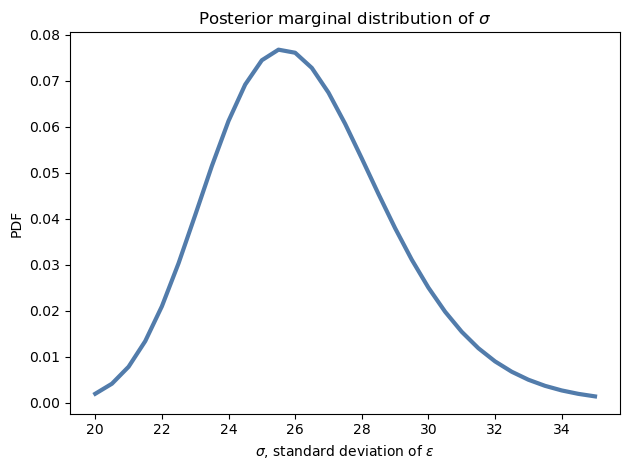

In [109]:
posterior_sigma.plot()

decorate(xlabel='$\sigma$, standard deviation of $\epsilon$', ylabel='PDF', title='Posterior marginal distribution of $\sigma$')

<br>

#### 절편 `Intercept`의 사후주변분포

In [115]:
results.params.Intercept

64.44632459660208

In [116]:
posterior_inter.max_prob()

64.5

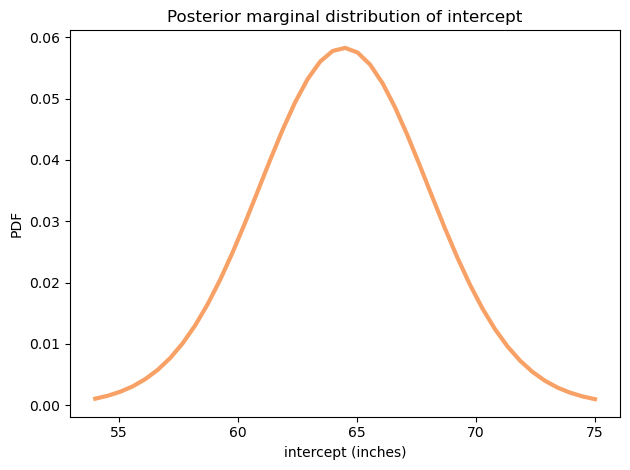

In [117]:
posterior_inter.plot(color='C1')
decorate(xlabel='intercept (inches)', ylabel='PDF', title='Posterior marginal distribution of intercept')

<br>

#### 회귀계수 `slope`의 사후주변분포
- 사후평균은 약 0.51인치 $\rightarrow$ 최소제곱회귀의 추정값과 유사
- **90% 신용구간은 [0.1에서 0.9] $\rightarrow$ 사후주변분포에 따른 추정값에 대한 불확실성이 높음**

In [123]:
results.params.x

0.5118799624349011

In [119]:
posterior_slope.max_prob()

0.5

In [126]:
posterior_slope.quantile(0.05), posterior_slope.quantile(0.95)

(array(0.1), array(0.9))

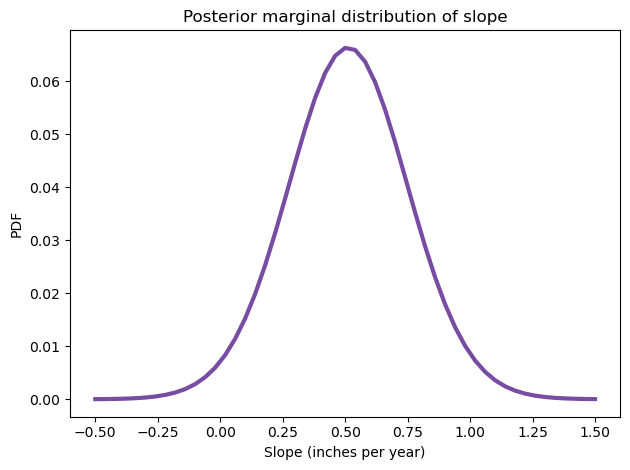

In [118]:
posterior_slope.plot(color='C4')
decorate(xlabel='Slope (inches per year)', ylabel='PDF', title='Posterior marginal distribution of slope')

<br>

#### 실제로 눈이 매녁 약 반 인치 정도씩 꾸준히 더 내리고 있다는 것을 알고 있음 (평균적으로 과거보다 현재가 25인치의 눈이 더 내림)
#### $\rightarrow$ 느린 추세와 잡음이 포함된 데이터는 직관을 흐리게 할 수 있음


<br>

## 17.07. 최적화

<br>

- 60,000의 사전분포크기에 대한 갱신속도 향상을 위한 최적화

<br>

* 행으로 'Slope'와 'Intercept'을, 열로 'sigma'가 있는 형태

In [127]:
joint3 = prior.unstack()
joint3.head(3)

Sigma                20.0      20.5      21.0      21.5      22.0      22.5  \
Slope Intercept                                                               
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   

Sigma                23.0      23.5      24.0      24.5  ...      30.5  \
Slope Intercept                                          ...             
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  ...  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  ...  0.000015   

Sigma                31.0      31.5      32.0      32.5      33.0      33.5  \
Slope Intercept                                                               
-0.5  54.000     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      54.525     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   
      55.050     0.000015  0.000015  0.000015  0.000015  0.000015  0.000015   

Sigma                34.0      34.5      35.0  
Slope Intercept                                
-0.5  54.000     0.000015  0.000015  0.000015  
      54.525     0.000015  0.000015  0.000015  
      55.050     0.000015  0.000015  0.000015  

[3 rows x 31 columns]


#### 위 형식의 사전결합분포로 갱신을 진행하는 '우도회귀' `likelihood regression`

In [129]:
from utils import normalize

In [130]:
def update_optimized(prior, data):

    xs = data['x']
    ys = data['y']
    sigmas = prior.columns    
    likelihood = prior.copy()

    for slope, inter in prior.index:
        expected = slope * xs + inter
        resid = ys - expected
        resid_mesh, sigma_mesh = np.meshgrid(resid, sigmas)
        densities = norm.pdf(resid_mesh, 0, sigma_mesh)
        likelihood.loc[slope, inter] = densities.prod(axis=1)
        
    posterior = prior * likelihood
    normalize(posterior)
    return posterior

<br>

#### 약 60,000회에 가까웠던 갱신 반복수가 2000대로 감소

In [131]:
len(prior_slope) * len(prior_inter)

2091

In [132]:
%time posterior_opt = update_optimized(joint3, data)

Wall time: 706 ms


In [133]:
np.allclose(posterior, posterior_opt.stack())

True

<br>

#### `sigma`의 사후주변분포

In [134]:
from utils import marginal

In [135]:
posterior2 = marginal(posterior_opt, 1)
posterior2.head(3)

Slope  Intercept
-0.5   54.000       7.633362e-08
       54.525       1.013295e-07
       55.050       1.327249e-07
Name: , dtype: float64

In [136]:
joint_posterior = posterior2.unstack().transpose()
joint_posterior.head(3)

Slope,-0.50,-0.46,-0.42,-0.38,-0.34,-0.30,-0.26,-0.22,-0.18,-0.14,...,1.14,1.18,1.22,1.26,1.30,1.34,1.38,1.42,1.46,1.50
Intercept,,,,,,,,,,,,,,,,,,,,,
54.000,7.633362e-08,1.244120e-07,1.999617e-07,3.168007e-07,4.945131e-07,7.601557e-07,0.000001,0.000002,0.000003,0.000004,...,0.000003,0.000002,0.000001,9.123148e-07,5.975833e-07,3.853761e-07,2.448104e-07,1.532653e-07,9.460588e-08,5.760046e-08
54.525,1.013295e-07,1.658787e-07,2.678095e-07,4.262364e-07,6.684267e-07,1.032304e-06,0.000002,0.000002,0.000003,0.000005,...,0.000004,0.000003,0.000002,1.272146e-06,8.301525e-07,5.333476e-07,3.375444e-07,2.105422e-07,1.294898e-07,7.856004e-08
55.050,1.327249e-07,2.182169e-07,3.538722e-07,5.657543e-07,8.912797e-07,1.382827e-06,0.000002,0.000003,0.000005,0.000007,...,0.000006,0.000004,0.000003,1.750579e-06,1.138148e-06,7.285261e-07,4.593750e-07,2.854925e-07,1.749592e-07,1.057750e-07


<br>

#### 등고선 시각화
- 등고선의 타원은 축과 정렬 $\rightarrow$ 사후주변분포의 'Slope'와 'Inter' 사이에 상관 관계가 없음

In [138]:
from utils import plot_contour

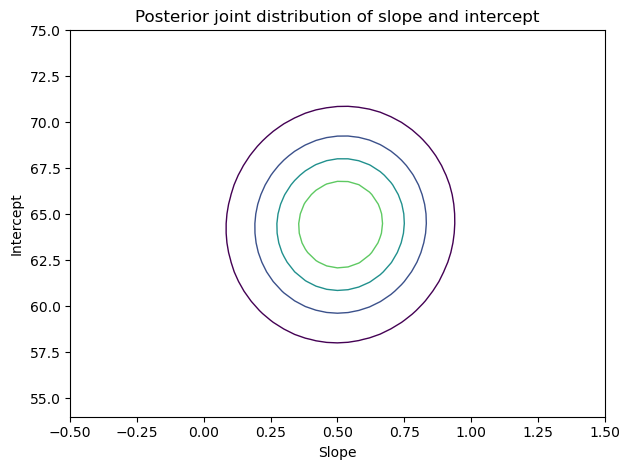

In [139]:
plot_contour(joint_posterior)
decorate(title='Posterior joint distribution of slope and intercept')

<br>

## 17.08. 마라톤 세계 신기록

> 마라톤 기록에 대하여 그래프를 그린다면, 그 결과는 뚜렷한 [직선 형태를 나타냄](http://allendowney.blogspot.com/2011/04/two-hour-marathon-in-2045.html)
>
> 또한 언제 마라톤 세계 신기록이 2시간 이내로 줄어들게 될 지에 대해 분석


In [154]:
url = 'https://en.wikipedia.org/wiki/Marathon_world_record_progression#Men'
tables = pd.read_html(url)
len(tables)

5

In [155]:
table = tables[0]
table.tail(3)

,Time,Name,Nationality,Date,Event/Place,Source,Notes
49,2:01:39,Eliud Kipchoge,Kenya,"September 16, 2018",Berlin Marathon,IAAF[89],NaN
50,2:01:09,Eliud Kipchoge,Kenya,"September 25, 2022",Berlin Marathon,World Athletics[90],NaN
51,2:00:35,Kelvin Kiptum,Kenya,"October 8, 2023",Chicago Marathon,World Athletics[91],First man to break 2:01:00 in the marathon.


In [156]:
table['date'] = pd.to_datetime(table['Date'], errors='coerce')
table['date'].head()

0   1908-07-24
1   1909-01-01
2   1909-02-12
3   1909-05-08
4          NaT
Name: date, dtype: datetime64[ns]

In [157]:
table['time'] = pd.to_timedelta(table['Time'])

In [158]:
table['y'] = 26.2 / table['time'].dt.total_seconds() * 3600
table['y'].head()

0    8.967143
1    9.099504
2    9.419942
3    9.465508
4    9.672854
Name: y, dtype: float64

<br>

#### **데이터 산점도**
- 각각의 점은 갈 수록 기울기가 늘어나는 것 같지만, 대략적인 직선 형태를 가지고 있음

In [159]:
def plot_speeds(df):

    plt.axhline(13.1, color='C5', ls='--')
    plt.plot(df['date'], df['y'], 'o', 
             label='World record speed', 
             color='C1', alpha=0.5)
    
    decorate(xlabel='Date',
             ylabel='Speed (mph)')

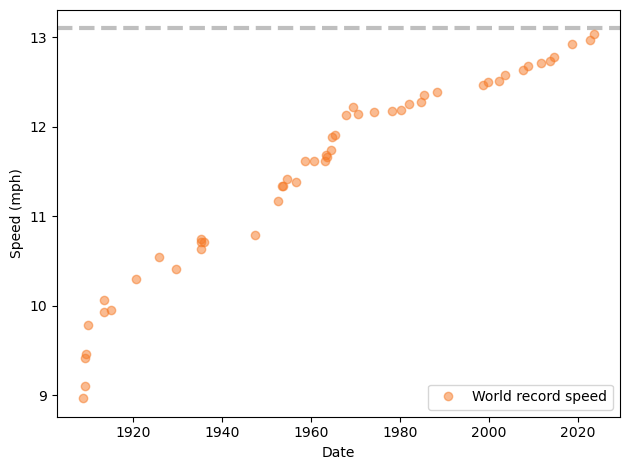

In [160]:
plot_speeds(table)

<br>

#### 1970년 이후의 데이터

* `date` : 세계 신기록이 깨진 날 (Timestamp)

* `speed` : 세계 신기록 페이스 (mph)


In [164]:
recent = table['date'] > pd.to_datetime('1970')
data = table.loc[recent].copy()
data.head()

,Time,Name,Nationality,Date,Event/Place,Source,Notes,date,time,y
32,2:09:28.8,Ron Hill,United Kingdom,"July 23, 1970","Edinburgh Commonwealth Games, Scotland",ARRS[10],NaN,1970-07-23,0 days 02:09:28.800000,12.140871
33,2:09:12,Ian Thompson,United Kingdom,"January 31, 1974","Christchurch Commonwealth Games, New Zealand",ARRS[10],NaN,1974-01-31,0 days 02:09:12,12.167183
34,2:09:05.6,Shigeru So,Japan,"February 5, 1978",Beppu-Ōita Marathon,ARRS[10],NaN,1978-02-05,0 days 02:09:05.600000,12.177236
35,2:09:01,Gerard Nijboer,Netherlands,"April 26, 1980",Amsterdam Marathon,ARRS[10],NaN,1980-04-26,0 days 02:09:01,12.184472
36,2:08:18,Robert De Castella,Australia,"December 6, 1981",Fukuoka Marathon,"IAAF,[53] ARRS[10]",NaN,1981-12-06,0 days 02:08:18,12.252533


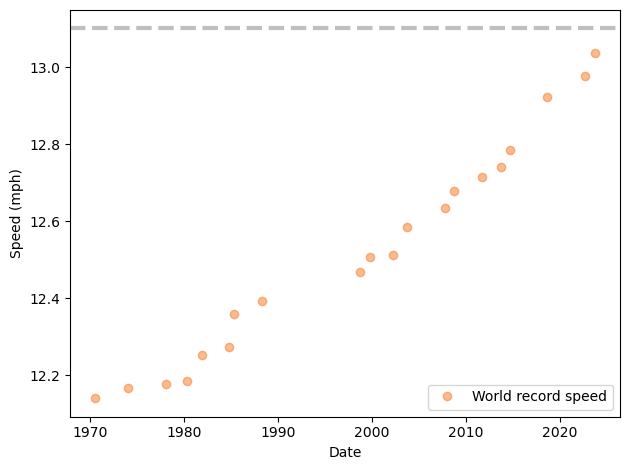

In [165]:
plot_speeds(data)

<br>

#### 전체 구간 중 중간 지점인 1995년의 값을 전체 데이터에서 빼는 표준화 (중심화 조정)

In [166]:
offset = pd.to_datetime('1995')
timedelta = table['date'] - offset

In [167]:
data['x'] = timedelta.dt.total_seconds() / 3600 / 24 / 365.24

<br>

#### 최소제곱회귀 적용을 통한 매개변수의 점 추정값 계산
- 추정 절편은 12.5 mph
- 추정 기울기는 연간 0.015 mph로, 세계 신기록 페이스가 꾸준히 증가

In [170]:
import statsmodels.formula.api as smf

In [171]:
formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    12.467888
x             0.016465
dtype: float64

- **잔차 표준편차 추정치**

In [172]:
results.resid.std()

0.04921878329328606

<br>

## 17.09. 베이즈갱신

<br>

### 각 매개변수별 균등 사전분포 생성

In [173]:
qs = np.linspace(0.012, 0.018, 51)
prior_slope = make_uniform(qs, 'Slope')

In [174]:
qs = np.linspace(12.4, 12.5, 41)
prior_inter = make_uniform(qs, 'Intercept')

In [175]:
qs = np.linspace(0.01, 0.21, 31)
prior_sigma = make_uniform(qs, 'Sigma')

### 사전결합분포 생성

In [176]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior.head()

Slope  Intercept  Sigma   
0.012  12.4       0.010000    0.000015
                  0.016667    0.000015
                  0.023333    0.000015
Name: , dtype: float64

<br>

### 가능도 계산

In [179]:
xs = data['x']
ys = data['y']
likelihood = prior.copy()

In [177]:
for slope, inter, sigma in prior.index:
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm.pdf(resid, 0, sigma)
    likelihood[slope, inter, sigma] = densities.prod()

<br>

### 갱신

In [178]:
posterior = prior * likelihood
posterior.normalize()

881359817814.0253

<br>

### 사후주변분포 계산

In [180]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

<br>

#### 잔차표준편차의 사후주변분포

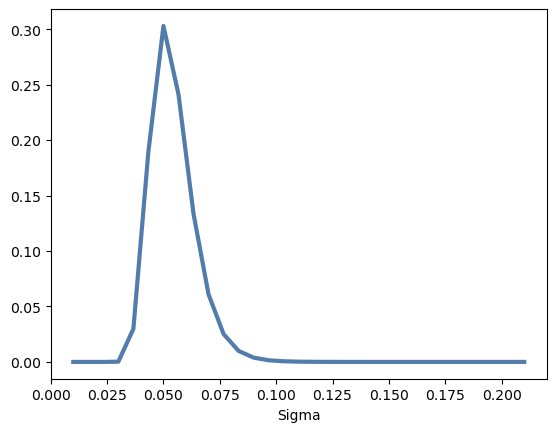

In [181]:
posterior_sigma.plot();

<br>

#### 절편의 사후주변분포

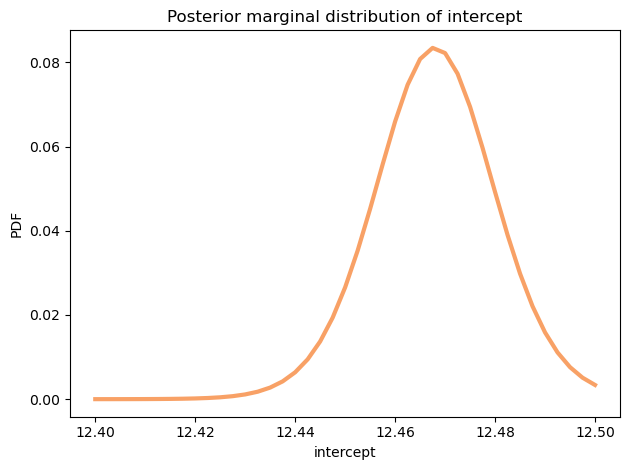

In [182]:
posterior_inter.plot(color='C1')
decorate(xlabel='intercept', ylabel='PDF', title='Posterior marginal distribution of intercept')

In [183]:
summarize(posterior_inter)

12.468 [12.4475 12.4875]


<br>

#### 회귀계수의 사후주변분포

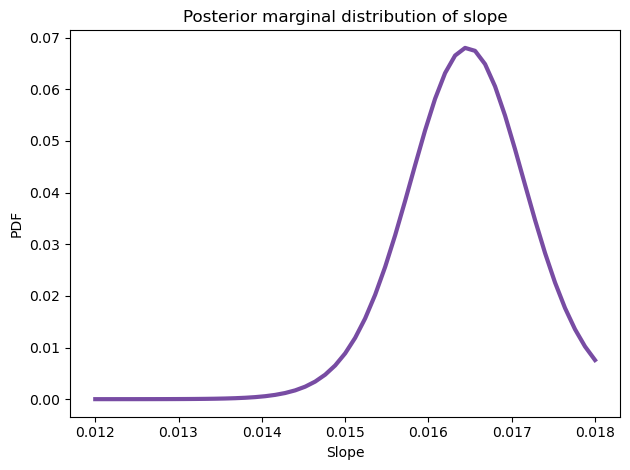

In [184]:
posterior_slope.plot(color='C4')
decorate(xlabel='Slope', ylabel='PDF', title='Posterior marginal distribution of slope')

In [185]:
summarize(posterior_slope)

0.016 [0.01524 0.01752]


<br>

## 17.10. 예측

<br>

#### 사후분포에서 임의의 매개변수 조합을 추출하고, 회귀 방정식을 만들어 데이터를 대입하는 방식의 예측

In [186]:
np.random.seed(17)

In [187]:
sample = posterior.choice(101)

In [189]:
xs = np.arange(-25, 50, 2)
pred = np.empty((len(sample), len(xs)))

In [195]:
for i, (slope, inter, sigma) in enumerate(sample):
    
    epsilon = norm(0, sigma).rvs(len(xs)) # 평균이 0, 표준편차가 sigma를 따르는 정규분포에서 난수 생성
    pred[i] = inter + slope * xs + epsilon

<br>

#### 예측값과 90% 신용구간

In [196]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)

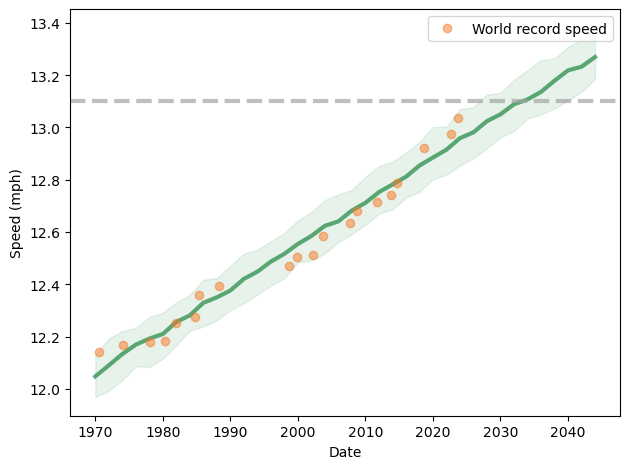

In [197]:
times = pd.to_timedelta(xs*365.24, unit='days') + offset

plt.fill_between(times, low, high,  color='C2', alpha=0.1)
plt.plot(times, median, color='C2')

plot_speeds(data)

<br>

#### 예측선과 목표 선이 교차하는 지점을 외삽

<br>

#### `scipy.interpolate.interpid()` : 선형 외삽법

In [199]:
from scipy.interpolate import interp1d

In [200]:
future = np.array([interp1d(high, xs)(13.1), interp1d(median, xs)(13.1), interp1d(low, xs)(13.1)])

In [201]:
dts = pd.to_timedelta(future*365.24, unit='day') + offset
pd.DataFrame(dict(datetime=dts),
             index=['early', 'median', 'late'])

,datetime
early,2026-12-13 03:14:27.202329600
median,2033-04-08 05:07:46.556428800
late,2039-10-31 21:59:58.551792000


#### 중간값 예측은 2036년, 90% 신뢰구간은 2032년에서 2043년 $\rightarrow$ 2032년 전에 2시간 이내 마라톤 기록을 볼 확률은 5%

## 17.12 예제


In [206]:
df = pd.read_csv('2239075.csv', parse_dates=[2])
df.head(3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TMAX,TMIN,TOBS,WESD,WT01,WT03,WT04,WT05,WT06,WT08,WT09,WT11,WT16,WT18
0,USC00190736,"BLUE HILL COOP, MA US",1967-05-11,0.43,0.0,0.0,57,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00190736,"BLUE HILL COOP, MA US",1967-05-12,0.00,0.0,0.0,58,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00190736,"BLUE HILL COOP, MA US",1967-05-13,0.00,0.0,0.0,64,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [207]:
df['YEAR'] = df['DATE'].dt.year

df['TMID'] = (df['TMIN'] + df['TMAX']) / 2

tmid = df.groupby('YEAR')['TMID'].mean()
len(tmid)

In [210]:
complete = tmid.iloc[1:-1]
len(complete)

52

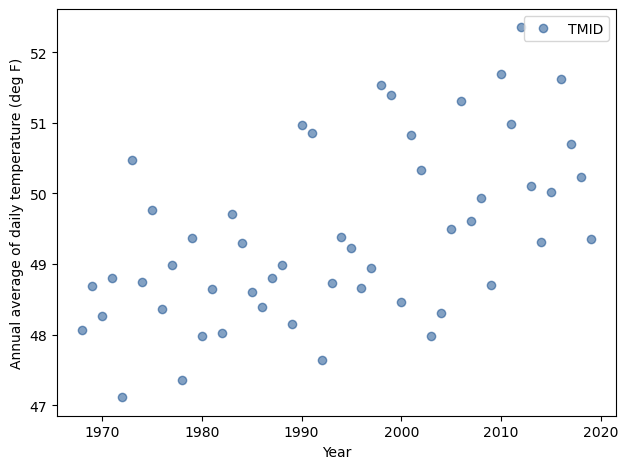

In [212]:
complete.plot(ls='', marker='o', alpha=0.5)

decorate(xlabel='Year', ylabel='Annual average of daily temperature (deg F)')

In [213]:
data = complete.reset_index()
data.head()

,YEAR,TMID
0,1968,48.071038
1,1969,48.687671
2,1970,48.258904
3,1971,48.804110
4,1972,47.112022


<br>

#### 평균을 통한 표준화

In [214]:
offset = round(data['YEAR'].mean())
offset

1994

In [215]:
data['x'] = data['YEAR'] - offset
data['x'].mean()

-0.5

In [216]:
data['y'] = data['TMID']
data['y'].std()

1.238911400962575

<br>

#### `statsmodel`을 사용해서 절편, 회귀계수, 잔차 표준편차에 대한 점추정

In [218]:
import statsmodels.formula.api as smf

formula = 'y ~ x'
results = smf.ols(formula, data=data).fit()
results.params

Intercept    49.430172
x             0.044252
dtype: float64

In [217]:
results.resid.std()

0.04921878329328606

<br>

#### 매개변수 별 사전분포 생성

In [220]:
qs = np.linspace(0, 0.1, num=51)
prior_slope = make_uniform(qs, 'Slope')

qs = np.linspace(48, 52, num=41)
prior_inter = make_uniform(qs, 'Intercept')

qs = np.linspace(0.5, 2, num=31)
prior_sigma = make_uniform(qs, 'Sigma')

<br>

#### 사전결합분포 생성

In [221]:
prior = make_joint3(prior_slope, prior_inter, prior_sigma)
prior.head()

Slope  Intercept  Sigma
0.0    48.0       0.50     0.000015
                  0.55     0.000015
                  0.60     0.000015
Name: , dtype: float64

<br>

#### 가능도 계산

In [223]:
xs = data['x']
ys = data['y']
likelihood = prior.copy()

In [224]:
for slope, inter, sigma in prior.index:
    
    expected = slope * xs + inter
    resid = ys - expected
    densities = norm.pdf(resid, 0, sigma)
    likelihood[slope, inter, sigma] = densities.prod()

<br>

#### 사후분포 생성

In [225]:
posterior = prior * likelihood
posterior.normalize()

6.471589606597477e-36

<br>

#### 사후주변분포 생성

In [226]:
posterior_slope = posterior.marginal(0)
posterior_inter = posterior.marginal(1)
posterior_sigma = posterior.marginal(2)

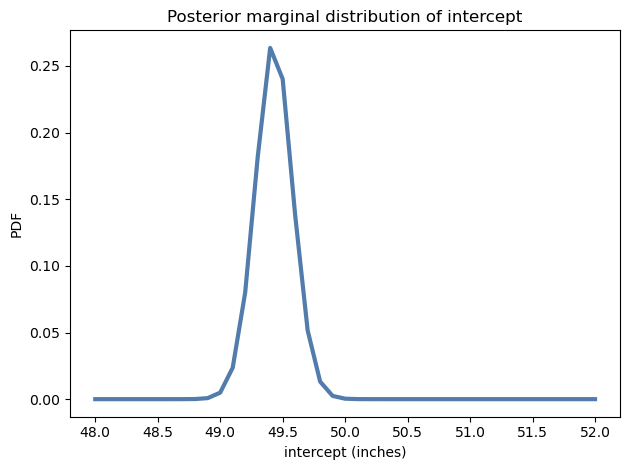

In [229]:
posterior_inter.plot()
decorate(xlabel='intercept (inches)', ylabel='PDF', title='Posterior marginal distribution of intercept')

In [230]:
posterior_inter.mean(), posterior_inter.credible_interval(0.9)

(49.430172755332116, array([49.2, 49.7]))

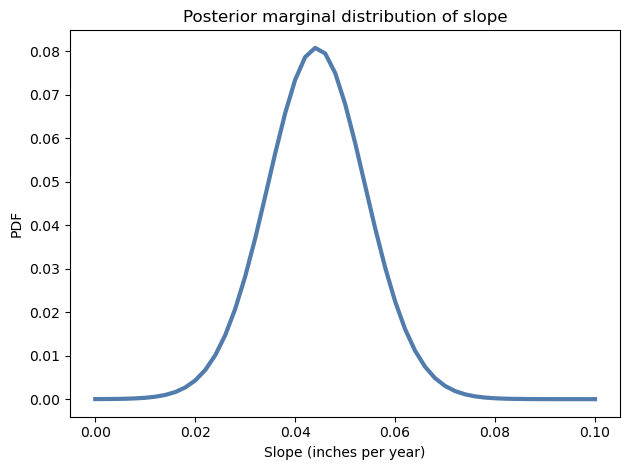

In [231]:
posterior_slope.plot()
decorate(xlabel='Slope (inches per year)', ylabel='PDF', title='Posterior marginal distribution of slope')

In [232]:
posterior_slope.mean(), posterior_slope.credible_interval(0.9)

(0.044253080678033144, array([0.028, 0.06 ]))

<br>

#### 사후분포로부터 매개변수 표본 추출을 통한 예측

In [233]:
sample = posterior.choice(101)

years = np.arange(1967, 2067, 2)
xs = years - offset

pred = np.empty((len(sample), len(xs)))
for i, (slope, inter, sigma) in enumerate(sample):
    pred[i] = inter + slope * xs + norm(0, sigma).rvs(len(xs))
    
pred.shape

(101, 50)

In [234]:
low, median, high = np.percentile(pred, [5, 50, 95], axis=0)
median.shape

(50,)

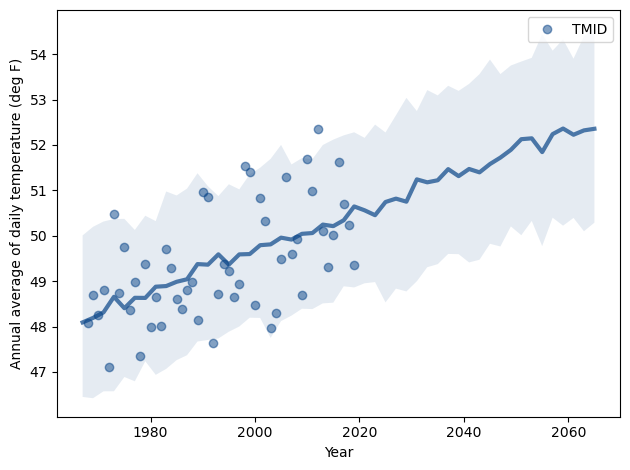

In [235]:
plt.fill_between(years, low, high, alpha=0.1)
plt.plot(years, median, color='C0')

complete.plot(ls='', marker='o', alpha=0.5)

decorate(xlabel='Year', ylabel='Annual average of daily temperature (deg F)')

In [236]:
median[-1] - median[0]

4.264154393858554